## **Tools to develop EEG event detection pipelines**
## See more detail about workshop here: thinknew.github.io/BCIWorkshop2024/

### Purpose
**This notebook aims to demonstrate usage of pre-developed code for time-series classification, specifically:**

* Demonstrate a preprocessing pipeline
* Develop and tune your own deep learning classification pipeline
* Evaluate the performance of applied methods

# Setting Up the Environment
The prerequisite packages to this tutorial are:


*   [**MNE**](https://mne.tools/stable/install/mne_python.html#installing-mne-python-and-its-dependencies): EEG Data Package
*   [**NumPy**](https://www.scipy.org/install.html): Numerical Computing (SciPy Download Page)
*   [**SciPy**](https://www.scipy.org/install.html): Scientific Computing
*   [**MatPlotLib**](https://matplotlib.org/users/installing.html): General Purpose Machine Learning Library
*   [**Scikit-Learn**](https://scikit-learn.org/stable/install.html): General Purpose Machine Learning Library
*   [**Tensorflow 2.0**](https://www.tensorflow.org/guide/effective_tf2/): Deep Learning Library from Google Brain
*   [**PyWavelets**](https://pywavelets.readthedocs.io/): Open source wavelet transform software
*   [**EntropyHub**](https://www.entropyhub.xyz/index.html): Open source toolkit for entropic data analysis

We will use pip to setup the environment. In your own local machine, consider using conda and the environment.yml file.

In [1]:
!pip install EntropyHub
!pip install mne
!pip install seaborn
!pip install PyWavelets
!pip install emd
!pip install pyxdf

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.8/158.8 kB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.6/74.6 kB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.1/82.1 kB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 13.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 13.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 13.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.3/85.3 kB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 237.3/237.3 kB 10.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 kB 6.7 MB/s eta 0:00:00


Import all of our required modules. Several functions have already been developed for use and are defined in:

* augmentations.py
* dsp.py
* features.py
* models.py
* utils.py


---


**Augmentations**

Contains the numpy implementation of time series data augmentations including transformations, pattern mixing, generative models, and decomposition ([Iwana B.K. & Uchida S., 2021](https://doi.org/10.1371/journal.pone.0254841) )

**Digital Signal Processing (DSP)**

Contains several signal processing functions for filtering, averaging, and transformations typically used in EEG analysis.

**Features**

Contains several calculations covering statisticaly, temporal, and frequency based features. Not all functions support multi-dimensional (> 1-D) calculation. Specifically, sample entropy, approximate entropy, PSD, zero-crossings, and peak functions take 1-D inputs only.

**Models**

Contains basic descriptions of linear and non-linear classification models. All models can be reached via the `'get_model'` function. Scikit-learn models may also be wrapped in a GridSearch hyperparameter optimisation function, see `'set_gridsearch'` and `'get_best_gridsearch'`. Confident users may adapt neural network architectures as desired.

**Utils**

Provides several functions for ease of use including sliding window process, model persistence, and model evaluation among others.

# Environment Setup

In [2]:
import emd
import mne
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from multiprocessing import Pool, cpu_count
from functools import partial
from itertools import repeat

from sklearn.datasets import load_iris

from utils import *
from dsp import run_hht, std_scale, notch_filter
from augmentations import *
from features import *
from models import *


In [3]:
# Set random seeds for reproducibility
tf.random.set_seed(42)
np.random.seed(42)

In [4]:
# Set window size and shift
window_size = 30
window_shift = 30

# Pipeline Overview
Steps

1.   Load data
2.   Preprocess
3.   Split dataset
4.   Initialise models
5.   Train
6.   Model persistence
7.   See evaluation



# Load Data

In [5]:
# Load data
from mne.datasets.sleep_physionet.age import fetch_data
ALICE, BOB = 0, 1

[alice_files, bob_files] = fetch_data(path='./mne_data/',
                                      subjects=[ALICE, BOB], recording=[1])

raw_train = mne.io.read_raw_edf(
    alice_files[0], stim_channel="Event marker", infer_types=True, preload=True
)

# Get the sample frequency from dataset, pre-set in config.py otherwise
time = raw_train.times
fs = np.round(np.mean(1/np.diff(time))).astype(int)
FS = fs

annot_train = mne.read_annotations(alice_files[1])

raw_train.set_annotations(annot_train, emit_warning=False)

annotation_desc_2_event_id = {
    "Sleep stage W": 0,
    "Sleep stage 1": 1,
    "Sleep stage 2": 2,
    "Sleep stage 3": 3,
    "Sleep stage 4": 3,
    "Sleep stage R": 4,
}

# keep last 30-min wake events before sleep and first 30-min wake events after
# sleep and redefine annotations on raw data
annot_train.crop(annot_train[1]["onset"] - 30 * 60,
                 annot_train[-2]["onset"] + 30 * 60)
raw_train.set_annotations(annot_train, emit_warning=False)

events_train, _ = mne.events_from_annotations(
    raw_train, event_id=annotation_desc_2_event_id, chunk_duration=window_size
)

# create a new event_id that unifies stages 3 and 4
event_id = {
    "Sleep stage W": 0,
    "Sleep stage 1": 1,
    "Sleep stage 2": 2,
    "Sleep stage 3/4": 3,
    "Sleep stage R": 4,
}

# # Ignore, removes irrelevant channels
# if 'ssvep' not in sample_data_raw_file.name:
#     channels = raw.ch_names
#     drop_channels = [ch for ch in channels if 'EEG' not in ch]
#     raw.drop_channels(drop_channels)
tmax = 30.0 - 1.0 / raw_train.info["sfreq"]  # tmax in included

epochs_train = mne.Epochs(
    raw=raw_train,
    events=events_train,
    event_id=event_id,
    tmin=0.0,
    tmax=tmax,
    baseline=None,
)
example_data = epochs_train.get_data()[:, :2, :]
# channels_last
example_data = np.swapaxes(epochs_train, 1, 2)
example_data = np.vstack(example_data)


100%|█████████████████████████████████████| 48.3M/48.3M [00:00<00:00, 31.0GB/s]
100%|█████████████████████████████████████| 4.62k/4.62k [00:00<00:00, 3.05MB/s]
100%|█████████████████████████████████████| 51.1M/51.1M [00:00<00:00, 18.2GB/s]
100%|█████████████████████████████████████| 3.90k/3.90k [00:00<00:00, 1.33MB/s]

Download complete in 02m54s (94.8 MB)
Extracting EDF parameters from /content/mne_data/physionet-sleep-data/SC4001E0-PSG.edf...
EDF file detected
Channel 'EEG Fpz-Cz' recognized as type EEG (renamed to 'Fpz-Cz').
Channel 'EEG Pz-Oz' recognized as type EEG (renamed to 'Pz-Oz').
Channel 'EOG horizontal' recognized as type EOG (renamed to 'horizontal').
Channel 'Resp oro-nasal' recognized as type RESP (renamed to 'oro-nasal').
Channel 'EMG submental' recognized as type EMG (renamed to 'submental').
Channel 'Temp rectal' recognized as type TEMP (renamed to 'rectal').
Setting channel info structure...
Creating raw.info structure...



<ipython-input-5-6b01a3cc8763>:8: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw_train = mne.io.read_raw_edf(
<ipython-input-5-6b01a3cc8763>:8: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw_train = mne.io.read_raw_edf(
<ipython-input-5-6b01a3cc8763>:8: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw_train = mne.io.read_raw_edf(


Reading 0 ... 7949999  =      0.000 ... 79499.990 secs...
Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 2', 'Sleep stage 3', 'Sleep stage 4', 'Sleep stage R', 'Sleep stage W']
Not setting metadata
841 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 841 events and 3000 original time points ...
0 bad epochs dropped


# Pre-process

In [6]:
# For Hilbert-Huang Transform
hht = []
f = []
freq_edges, freq_centres = emd.spectra.define_hist_bins(0, 5, 5*50, 'linear')

data = example_data.copy()

In [7]:
# Let's look at 1 channel only
ch_norm = std_scale(data[:, 0]).T
# Return windowed data (N, T, C)
ch_wins = get_windows(ch_norm, int(window_size*FS), int(window_shift*FS))

In [8]:
# For faster computations, let's only look at 200 samples
nsamples = 200
random_samples = np.random.randint(len(ch_wins), size=nsamples)

In [9]:
x = ch_wins[random_samples]
y = events_train.copy()[random_samples, -1]

# Split Dataset

We split the dataset before completing any feature calculations and transforms. This is to introduce augmentations to the training dataset only.

In [10]:
# Random shuffle split to train and test sets.
x_train, x_test, y_train, y_test = split_dataset(x, y)

In [11]:
def apply_augs(data):
    ''' A function to apply augmentations
    :param data: numpy-like array of shape (N, T, C)'''
    data_augs = jitter(data)
    data_augs = scaling(data_augs)
    return data_augs

In [12]:
def get_my_features(data, fname):
  '''Returns presaved features from fname suffix, otherwise, calculates features
  and HHT. Features are saved to pkl format and HHT frequency and magnitude is
  saved as .npy
  :param data: 1-D numpy-like array to calculate features and transforms
  :type fname: Filename string suffix for calculations. Typically set as train
  or test.'''
  feat_fname = 'features_'+fname+'.pkl'
  freq_fname = 'freqs_'+fname+'.npy'
  hht_fname = 'hht_' + fname+'.npy'
  try:
    return pd.read_pickle(feat_fname), np.load(freq_fname), np.load(hht_fname)
  except:
    with Pool(cpu_count()) as p:
        tmp_dict = p.map(m_func, data)
        hht = p.starmap(run_hht, zip((data), repeat(freq_edges)))
  # Create train and test dataframes from dictionary inputs
  df = pd.DataFrame(tmp_dict)
  df.to_pickle(feat_fname)

  # Create array of augmented train HHT and non-augmented test HHT
  f, hht_ = zip(*hht)
  f = f[0]
  hht = np.array(hht_)
  np.save('freqs_'+fname, f)
  np.save('hht_'+fname, hht)
  return df, f, hht

In [13]:
# apply augmentations
x_train_aug = apply_augs(x_train)

tmp_dict = []
m_func = partial(return_all_features, ch=0)

df_train, f, hht_train = get_my_features(x_train_aug, 'train')
df_test, _, hht_test = get_my_features(x_test, 'test')

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


In [14]:
# What does our feature data look like?
print(df_train.head())

   ch0_mean   ch0_std  ch0_median   ch0_max   ch0_min  ch0_pk2pk  ch0_skew  \
0  0.006273  1.299327   -0.012724  5.912607 -5.505606  11.418214  0.200259   
1 -0.000294  1.690022    0.088469  4.581168 -5.648501  10.229669 -0.072501   
2 -0.007647  0.360709   -0.017990  1.250281 -1.285835   2.536116  0.142587   
3  0.003543  1.124909    0.003950  4.163098 -4.362515   8.525612 -0.057462   
4  0.020398  1.240378   -0.048318  4.696968 -4.586278   9.283246  0.172449   

   ch0_kurtosis  ch0_sample_entropy  ch0_approx_entropy  ...   ch0_rms  \
0      2.729355            1.044881            1.220741  ...  1.299342   
1      0.033743            1.066793            1.139117  ...  1.690022   
2     -0.089649            0.488269            0.540270  ...  0.360790   
3      2.159996            0.706317            0.965552  ...  1.124915   
4      0.441770            0.989432            1.093236  ...  1.240546   

   ch0_max_freq  ch0_mean_power_band_0  ch0_mean_power_band_1  \
0          0.55      

(<Figure size 1000x600 with 1 Axes>,
 <Axes: title={'center': 'Transform Plot'}>)

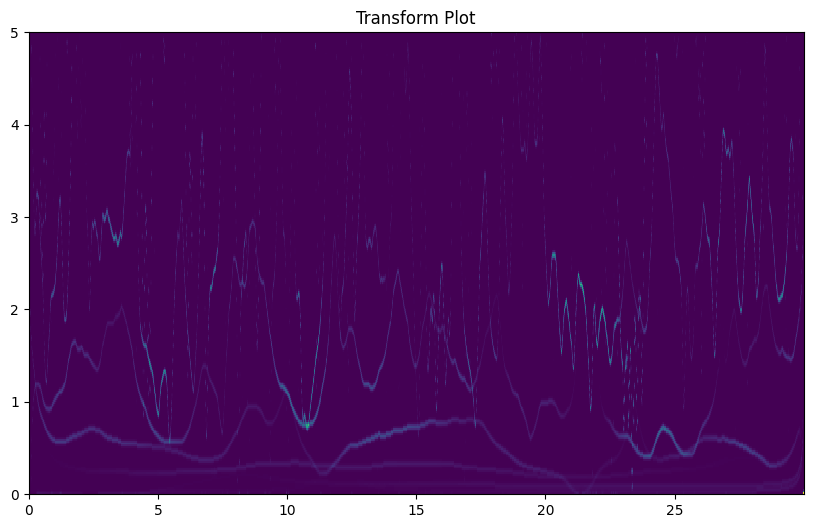

In [15]:
# What does the HHT look like?
plot_channel_transform(time[:int(window_size*FS)], f, hht_test[10])

In [16]:
# Setup features for training
x_feats_train = df_train.values.astype('float32')
x_feats_test = df_test.values.astype('float32')

In [17]:
# Perform One Hot Encoding on labels
y_ohe, ohe = do_one_hot(y.reshape(-1, 1))

y_train_ohe = ohe.transform(y_train.reshape(-1,1)).toarray().astype(int)
y_test_ohe = ohe.transform(y_test.reshape(-1,1)).toarray().astype(int)

# Model Initialisation

In [18]:
fnn = get_model('fnn', n_classes=len(np.unique(y)))
lda = get_model('lda', n_classes=len(np.unique(y)))

# Model Training and Evaluation

The fully connected neural network (FNN) trains on the preprocessed and augmented windowed data while the linear discriminant analysis (LDA) model trains on extracted features from augmented training sets.

## Neural Network

In [19]:
fnn.compile_model()
fnn.fit_model(x_train_aug, y_train_ohe, validation_split=0.2)
y_hat_fnn = fnn.model.predict(x_test)

Epoch 1/10
4/4 [==============================] - 4s 593ms/step - loss: 7.4425 - categorical_accuracy: 0.2266 - val_loss: 5.4337 - val_categorical_accuracy: 0.2500
Epoch 2/10
4/4 [==============================] - 3s 818ms/step - loss: 3.0191 - categorical_accuracy: 0.5391 - val_loss: 4.4778 - val_categorical_accuracy: 0.3125
Epoch 3/10
4/4 [==============================] - 2s 501ms/step - loss: 1.3396 - categorical_accuracy: 0.6094 - val_loss: 3.3074 - val_categorical_accuracy: 0.3438
Epoch 4/10
4/4 [==============================] - 2s 485ms/step - loss: 0.8347 - categorical_accuracy: 0.7578 - val_loss: 2.9436 - val_categorical_accuracy: 0.3438
Epoch 5/10
4/4 [==============================] - 2s 487ms/step - loss: 0.4613 - categorical_accuracy: 0.8438 - val_loss: 3.4450 - val_categorical_accuracy: 0.3438
Epoch 6/10
4/4 [==============================] - 2s 505ms/step - loss: 0.1655 - categorical_accuracy: 0.9219 - val_loss: 3.3234 - val_categorical_accuracy: 0.3750
Epoch 7/10
4/4 [

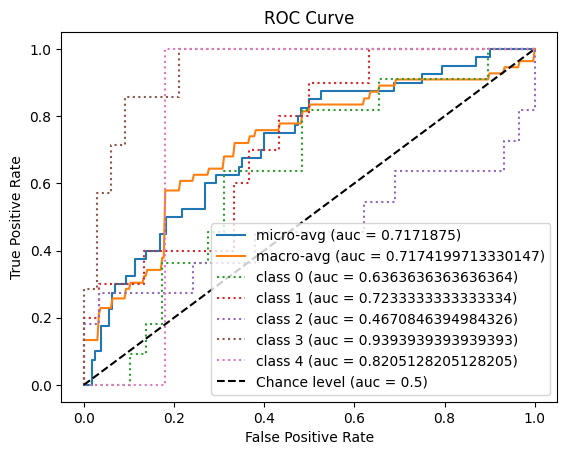

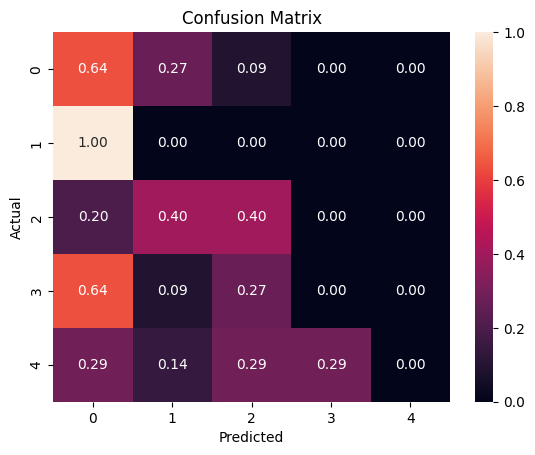

              precision    recall  f1-score   support

           0       0.37      0.64      0.47        11
           1       0.00      0.00      0.00         1
           2       0.40      0.40      0.40        10
           3       0.00      0.00      0.00        11
           4       0.00      0.00      0.00         7

    accuracy                           0.28        40
   macro avg       0.15      0.21      0.17        40
weighted avg       0.20      0.28      0.23        40



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [20]:
plt.figure()
plot_roc_curve(y_test_ohe, y_hat_fnn)

pred = np.argmax(y_hat_fnn, axis=1)
plt.figure()
plot_confusion_matrix(y_test, pred, labels=np.arange(N_CLASSES))

show_classifier_performance(y_test, pred)

## LDA

In [21]:
lda.fit(x_feats_train, y_train)
y_hat_lda = lda.predict_proba(x_feats_test)

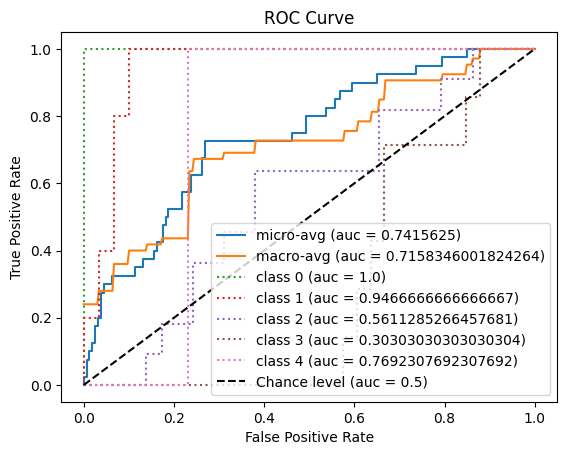

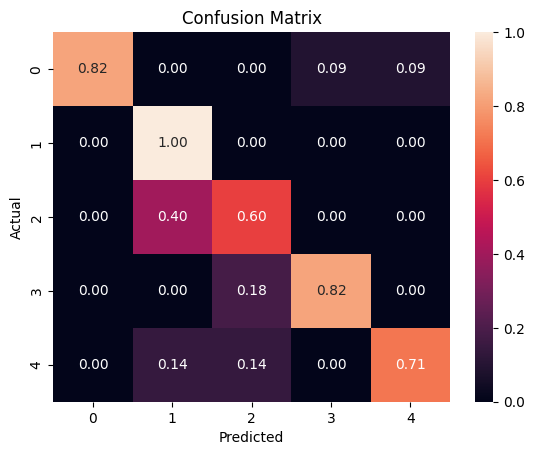

              precision    recall  f1-score   support

           0       1.00      0.82      0.90        11
           1       0.17      1.00      0.29         1
           2       0.67      0.60      0.63        10
           3       0.90      0.82      0.86        11
           4       0.83      0.71      0.77         7

    accuracy                           0.75        40
   macro avg       0.71      0.79      0.69        40
weighted avg       0.84      0.75      0.78        40



In [22]:
plt.figure()
plot_roc_curve(y_test_ohe, y_hat_lda)

pred = np.argmax(y_hat_lda, axis=1)
plt.figure()
plot_confusion_matrix(y_test, pred, labels=np.arange(N_CLASSES))

show_classifier_performance(y_test, pred)

In [23]:
# Save models for later use
save_model(fnn.model, 'fnn')
save_model(lda, 'lda')

saved to  ./trained_models/fnn.keras
saved to  ./trained_models/lda.joblib


In [24]:
# Load models
my_fnn_model = load_model('./trained_models/fnn.keras')

In [25]:
my_lda_model = load_model('./trained_models/lda.joblib')